In [425]:
import os
import sys

sys.path.append('../')
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from matplotlib.colors import LogNorm, Normalize
from scipy.ndimage import gaussian_filter
from skimage import io
from skimage.transform import resize

from kwave.ktransducer import kWaveGrid
from utils.dataio import *
from utils.simulations import get_water_sos
from utils.visualization import normalize

plt.rcParams['font.weight'] = 'semibold'

norm_sos = Normalize(vmax=1610, vmin=1490)
norm = Normalize(vmax=0.0, vmin=1.0)

data_path = '../data/'

First, we need to define the size and resolution of the image. In this project, the initial pressure and speed of sound distribution have the same reolsution as the KWave computational grid used in simulations.

In [426]:
Nx, Ny = 560, 560
dx, dy = 4.e-5, 4.e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())

### Initial Pressure

We simulate an image of the initial pressure distribution of mouse liver. We used this [Labeled cross-sectional anatomy of the mouse on micro-CT](https://www.imaios.com/en/vet-anatomy/mouse/mouse-whole-body) as reference.

In [427]:
# Circles
structures = {
    'body': (9.8e-3, 9.6e-3, 0.7, (0, 0)),
    'tissue': (9.62e-3, 0, 0.02, (0, 0)),
    'liver': (7.5e-3, 7.3e-3, 0.8, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1.1e-3, 0.9, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 0.0, 0.8, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 2.1e-3, 0.8, (3e-3, -0.7e-3)),
    'intestine lumen': (1.5e-3, 1.3e-3, 0.8, (-3.6e-3, 3.5e-3)),
    'dot': (0.25e-3, 0, 0.9, (3.5e-3, 1e-3))
}
# (Rout, Rin, pixel value, center location)
x_c, y_c = 0, 1.7e-3
x_vec, y_vec = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
IP = np.ones((Ny, Nx)) * 0.
for key, (R_out, R_in, p, offset) in structures.items():
    if 'dot' in key:
        IP[((x_vec - offset[0])**2 + (y_vec - y_c - offset[1])**2 < R_out**2) & ((x_vec - offset[0])**2 + (y_vec - y_c - offset[1])**2 >= R_in ** 2)] = p
        IP[((x_vec + offset[0])**2 + (y_vec - y_c + offset[1])**2 < R_out**2) & ((x_vec + offset[0])**2 + (y_vec - y_c + offset[1])**2 >= R_in ** 2)] = p
    else:
        IP[((x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R_out**2) & ((x_vec - offset[0])**2 + (y_vec - offset[1])**2 >= R_in ** 2)] = p

# lines
structures = {
    'vessel1': (-6.5e-3, 6.35e-3, -7.3e-3, 5.35e-3, 2.6e-7, 1.0),
    'vessel2': (-4.8e-3, 7.9e-3, -3.7e-3, 8.6e-3, 2.5e-7, 1.0),
    'line1': (-1.1e-3, -1.1e-3, -4.5e-3, -4.5e-3, 2.7e-7, 0.8),
    'line2': (2.e-3, 2.e-3, 2.1e-3, 5e-3, 2.5e-7, 0.8),
    'line3': (3.e-3, 3.e-3, 5.e-3, 3.1e-3, 2.3e-7, 0.8),
    'line4': (3.5e-3, 3.5e-3, 3.2e-3, 5.4e-3, 1.4e-7, 0.8),
    'line5': (3.9e-3, 3e-3, 3.7e-3, 1.8e-3, 0.8e-7, 0.8),
    'line6': (2.1e-3, 4e-3, 0.7e-3, 3.7e-3, 1.e-7, 0.8),
}
# (x1, y1, x2, y2, line thickness, pixel value)
for key, (x1, y1, x2, y2, w, p) in structures.items():
    if 'vessel' in key:
        IP[(np.abs((x2-x1)*y_vec - (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec-x1)*(x_vec-x2) <= 0) & ((y_vec-y1)*(y_vec-y2) <= 0)] = p
        IP[(np.abs(-(x2-x1)*y_vec - (y2-y1)*x_vec - x1*y2 + x2*y1) < w) & ((x_vec+x1)*(x_vec+x2) <= 0) & ((y_vec-y1)*(y_vec-y2) < 0)] = p
    elif 'line' in key:
        IP[(np.abs((x2-x1)*(y_vec-y_c) - (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec-x1)*(x_vec-x2) <= 0) & ((y_vec-y_c-y1)*(y_vec-y_c-y2) <= 0)] = p
        IP[(np.abs(-(x2-x1)*(y_vec-y_c) + (y2-y1)*x_vec + x1*y2 - x2*y1) < w) & ((x_vec+x1)*(x_vec+x2) <= 0) & ((y_vec-y_c+y1)*(y_vec-y_c+y2) <= 0)] = p
        
IP = gaussian_filter(IP, sigma=1, radius=6)

<Figure size 500x500 with 0 Axes>

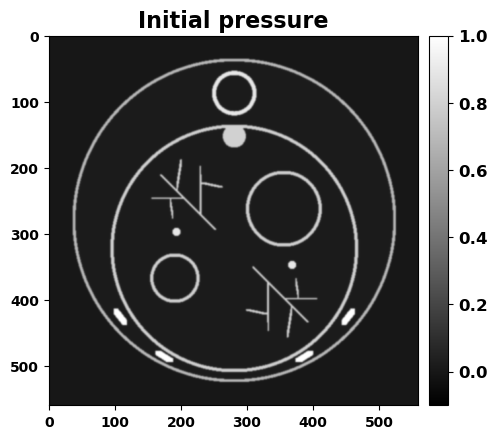

In [428]:
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots()
plt.title('Initial pressure', fontsize=16, fontweight='semibold')
plt.imshow(IP, norm=norm, cmap='gray')
cax = fig.add_axes([ax.get_position().x1+0.017, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tick_params(labelsize=12)

Save the initial pressure image.

In [429]:
save_mat(os.path.join(data_path, 'IP.mat'), IP.swapaxes(0,1), 'IP')

The initial pressure used in APACT's numerical phantom.

In [430]:
ip_apact_1 = io.imread(os.path.join(data_path, 'P0_2.bmp'))
ip_apact_2 = io.imread(os.path.join(data_path, 'P0_3.bmp'))
H, W, _ = ip_apact_1.shape
half_window = 192
ip_apact_1 = resize(ip_apact_1[H//2-half_window:H//2+half_window, W//2-half_window:W//2+half_window, 0], (Nx, Ny), anti_aliasing=True)
ip_apact_2 = resize(ip_apact_2[H//2-half_window:H//2+half_window, W//2-half_window:W//2+half_window, 0], (Nx, Ny), anti_aliasing=True)
ip_apact_1 = 1-normalize(ip_apact_1)
ip_apact_2 = 1-normalize(ip_apact_2)
ip_apact_1 = F.rotate(torch.from_numpy(ip_apact_1).unsqueeze(0), angle=-43).squeeze(0).numpy()

In [431]:
structures = {
    'body': (9.8e-3, 9.6e-3, 0.5, (0, 0)),
    'vertebral column': (1.35e-3, 1.1e-3, 0.6, (0, -7.7e-3)),
}

for key, (R_out, R_in, p, offset) in structures.items():
    ip_apact_1[((x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R_out**2) & ((x_vec - offset[0])**2 + (y_vec - offset[1])**2 >= R_in ** 2)] = p

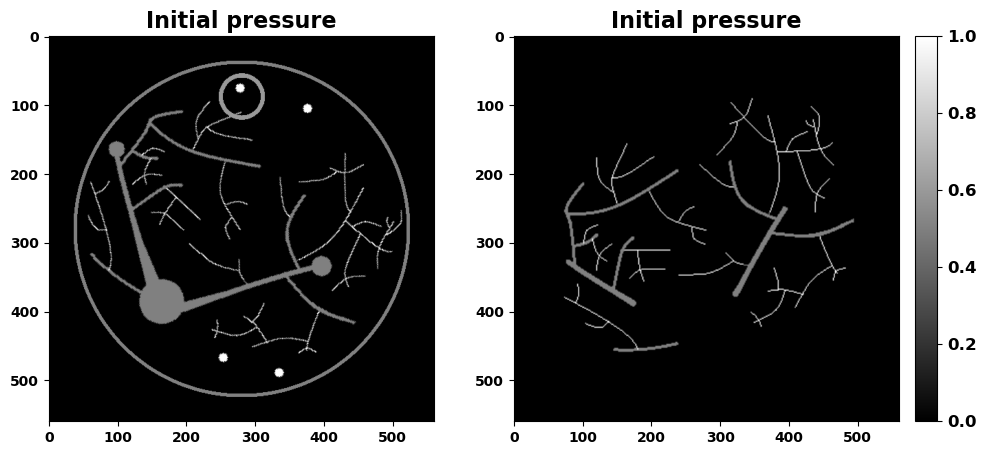

In [432]:
fig = plt.figure(figsize=(11, 5))
norm = Normalize(vmax=1.0, vmin=0.0)
for idx, ip in enumerate([ip_apact_1, ip_apact_2]):
    ax = plt.subplot(1,2,idx+1)
    plt.title('Initial pressure', fontsize=16, fontweight='semibold')
    plt.imshow(ip, norm=norm, cmap='gray')
    if idx == 1:
        cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.ax.tick_params(labelsize=12)
        cb.ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        plt.tick_params(labelsize=12)

In [433]:
save_mat(os.path.join(data_path, 'IP_APACT_1.mat'), ip_apact_1.swapaxes(0,1), 'IP')
save_mat(os.path.join(data_path, 'IP_APACT_2.mat'), ip_apact_2.swapaxes(0,1), 'IP')

### Speed of Sound

Now we simulate the speed of sound distribution. The structures in the SOS match the initial pressure image, and the SOS values are picked according to [experimentally measured data](https://itis.swiss/virtual-population/tissue-properties/database/acoustic-properties/speed-of-sound/).

The SOS in water is a polynomial function of temperature. The parameters we used are measure in [this paper](https://doi.org/10.1121/1.420332).

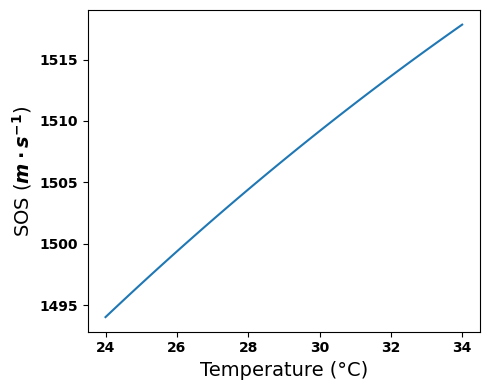

In [434]:
ts = np.linspace(24, 34, 100)
vs = [get_water_sos(t) for t in ts]
plt.figure(figsize=(5, 4))
plt.plot(ts, vs)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('SOS ($m \cdot s^{-1}$)', fontsize=14)
plt.xlim(23.5, 34.5)
plt.tight_layout()

In [435]:
T = 26.0
v0 = get_water_sos(T)   # SOS of the two circles. [m/s]
structures = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'liver': (7.5e-3, 1585.7, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 2500, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1578.2, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1510, 1, (3e-3, -0.7e-3)),
    'bone': (1.5e-3, 2500, 1908, (-3.6e-3, 3.5e-3)),
}

structures_apact = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'liver': (7.5e-3, 1575, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1650, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1578, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1510, 1, (3e-3, -0.7e-3)),
    'bone': (1.3e-3, 1670, 1908, (-4.6e-3, 4.2e-3)),
}

structures_easy = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'liver': (7.5e-3, 1575, 1079, (0, 1.7e-3)),
    'vertebral column': (1.35e-3, 1650, 1908, (0, -7.7e-3)),
    'spinal cord': (1.1e-3, 1542.0, 1075, (0, -7.7e-3)),
    'abdominal aorta': (0.7e-3, 1578, 1050, (0, -5.1e-3)), 
    'stomach lumen': (2.3e-3, 1510, 1, (3e-3, -0.7e-3)),
    'bone': (1.5e-3, 1650, 1908, (-3.6e-3, 3.5e-3)),
}
# (radius, sound speed, density, center location)

Complete SOS used in numerical phantom.

In [436]:
SOS = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures.items():
    SOS[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

SOS with structures matching APACT's numerical phantom.

In [437]:
SOS_apact = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures_apact.items():
    SOS_apact[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v

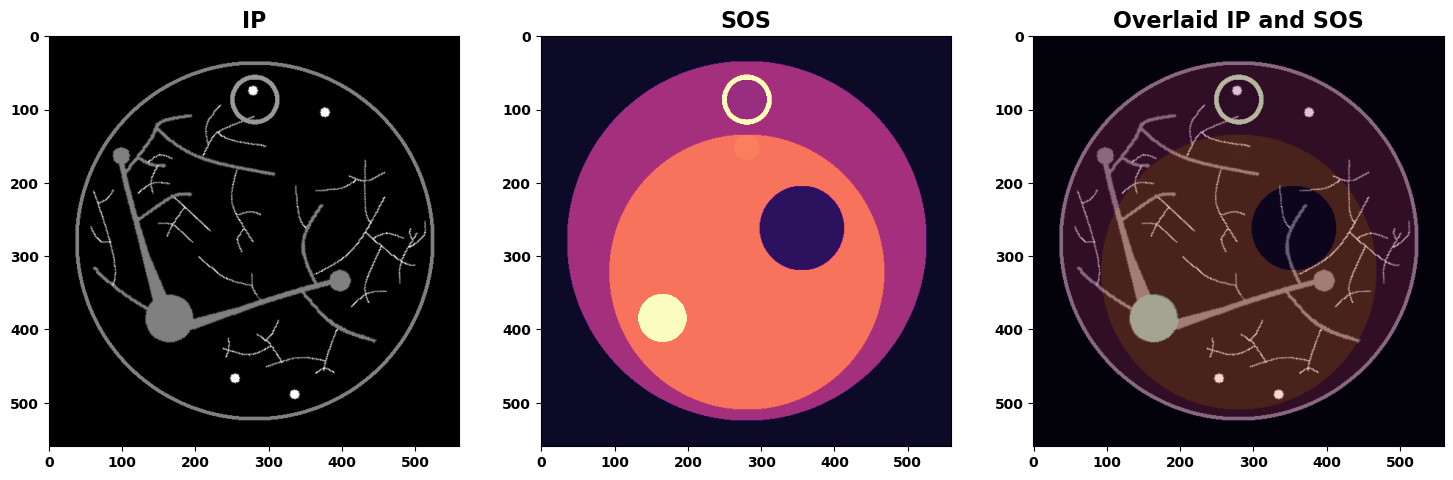

In [438]:
fig = plt.figure(figsize=(18, 6))
norm = Normalize(vmax=1.0, vmin=0.0)

plt.subplot(1,3,1)
plt.title('IP', fontsize=16, fontweight='semibold')
plt.imshow(ip_apact_1, norm=norm, cmap='gray')

plt.subplot(1,3,2)
plt.title('SOS', fontsize=16, fontweight='semibold')
plt.imshow(SOS_apact, norm=norm_sos, cmap='magma')

plt.subplot(1,3,3)
plt.title('Overlaid IP and SOS', fontsize=16, fontweight='semibold')
plt.imshow(ip_apact_1, norm=norm, cmap='gray')
plt.imshow(SOS_apact, norm=norm_sos, cmap='magma', alpha=0.3)


Easy SOS (numerical 0).

In [439]:
SOS_easy = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures_easy.items():
    SOS_easy[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    # density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

SOS with errors.

In [440]:
SOS_error = np.ones((Ny, Nx)) * v0
density = np.ones((Ny, Nx)) * 994
for key, (R, v, rou, offset) in structures_error.items():
    SOS_error[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    # density[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = rou

Body only.

In [441]:
SOS_body = np.ones((Ny, Nx)) * v0
for key in ['body']:
    (R, v, rou, offset) = structures[key]
    SOS_body[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v

Body + liver. (numerical 1)

In [442]:
SOS_body_liver = np.ones((Ny, Nx)) * v0
for key in ['body', 'liver']:
    (R, v, rou, offset) = structures_easy[key]
    SOS_body_liver[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v # Draw ring.

Single-body SOS. (numerical 2)

In [443]:
average_SOS = 1560 # np.mean(SOS_easy[x_vec**2 + y_vec**2 < (9.8e-3)**2])
print(v0, average_SOS)

SOS_SB = np.ones((Ny, Nx)) * v0
SOS_SB[x_vec**2 + y_vec**2 < (9.8e-3)**2] = average_SOS

1499.3632858457756 1560


Uniform SOS.

In [444]:
SOS_uniform = np.ones((Ny, Nx)) * v0

SOS with holes (mimics leaf phantom).

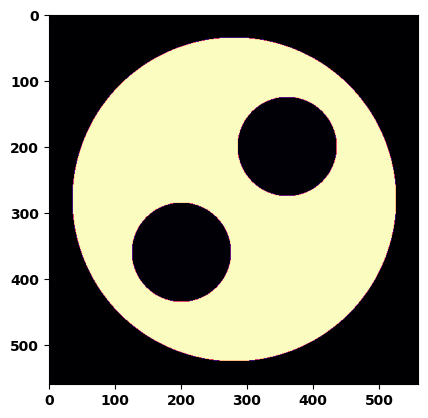

In [445]:
structures_holes = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'stomach lumen1': (3.0e-3, 1500, 1, (-3.2e-3, 3.2e-3)),
    'stomach lumen2': (3.0e-3, 1500, 1, (3.2e-3, -3.2e-3)),
}

SOS_holes = np.ones((Ny, Nx)) * v0
for key, (R, v, rou, offset) in structures_holes.items():
    SOS_holes[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    
plt.imshow(SOS_holes, cmap='magma')

SOS with multiple objects.

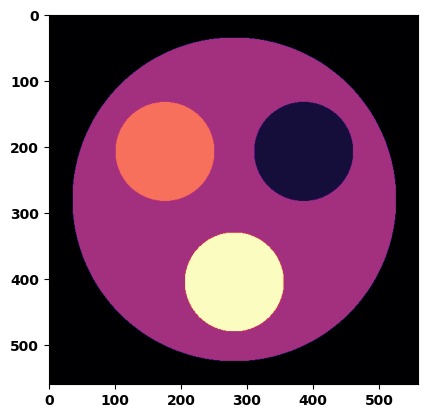

In [446]:
structures_circles = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'stomach lumen': (3.0e-3, 1510, 1, (4.2e-3, -2.9e-3)),
    'liver1': (3.0e-3, 1570, 1079, (-4.2e-3, -2.9e-3)),
    'liver2': (3.0e-3, 1600, 1079, (-0.0e-3, 5.0e-3)),
}

SOS_circles = np.ones((Ny, Nx)) * v0
for key, (R, v, rou, offset) in structures_circles.items():
    SOS_circles[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    
plt.imshow(SOS_circles, cmap='magma')

Single-body with bones.

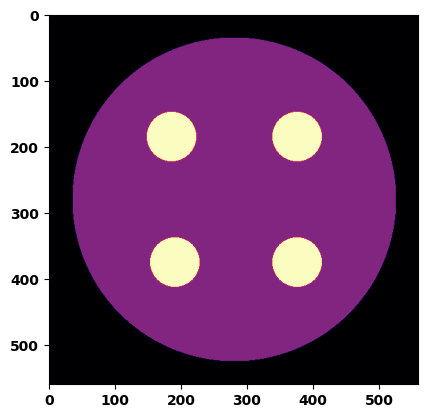

In [447]:
structures_body_bones = {
    'body': (9.8e-3, 1545, 1027, (0, 0)),
    'bone1': (1.5e-3, 1620, 1908, (3.8e-3, 3.8e-3)),
    'bone2': (1.5e-3, 1620, 1908, (-3.6e-3, 3.8e-3)),
    'bone3': (1.5e-3, 1620, 1908, (3.8e-3, -3.8e-3)),
    'bone4': (1.5e-3, 1620, 1908, (-3.8e-3, -3.8e-3)),
}

SOS_bones = np.ones((Ny, Nx)) * v0
for key, (R, v, rou, offset) in structures_body_bones.items():
    SOS_bones[(x_vec - offset[0])**2 + (y_vec - offset[1])**2 < R**2] = v
    
plt.imshow(SOS_bones, cmap='magma')

Visualize all SOS distributions.

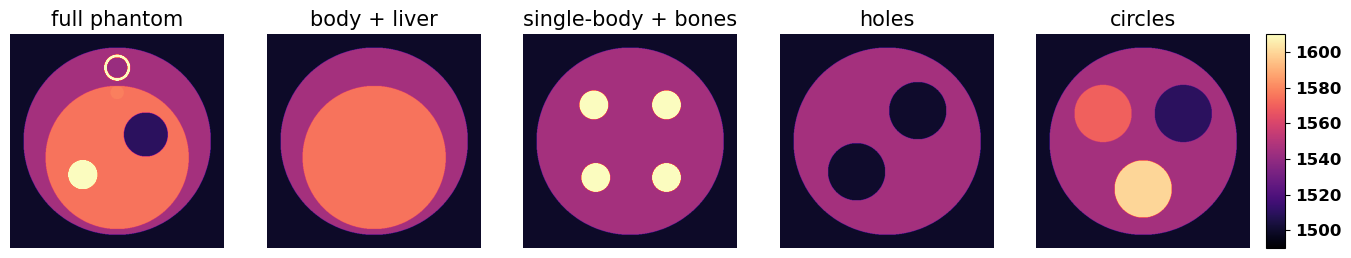

In [448]:
fig = plt.figure(figsize=(16, 5))
for idx, (SOS, name) in enumerate(zip([SOS_easy, SOS_body_liver, SOS_bones, SOS_holes, SOS_circles],
                              ['full phantom', 'body + liver', 'single-body + bones', 'holes', 'circles'])):
    ax = plt.subplot(1,5,idx+1)
    plt.imshow(SOS, norm=norm_sos, cmap='magma')
    plt.title(name, fontsize=15)
    plt.axis('off')
    if idx == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)
        cb.ax.tick_params(labelsize=12)

Save the SOS distributions for simulations and the SOS figure.

In [449]:
# save_mat(os.path.join(data_path, 'density.mat'), density.swapaxes(0,1), 'density')
save_mat(os.path.join(data_path, 'SOS.mat'), SOS.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_full.mat'), SOS_easy.swapaxes(0,1), 'SOS') # 0
save_mat(os.path.join(data_path, 'SOS_apact.mat'), SOS_apact.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_SB.mat'), SOS_SB.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_body.mat'), SOS_body.swapaxes(0,1), 'SOS')
save_mat(os.path.join(data_path, 'SOS_bones.mat'), SOS_bones.swapaxes(0,1), 'SOS') # 2TADY
save_mat(os.path.join(data_path, 'SOS_body_liver.mat'), SOS_body_liver.swapaxes(0,1), 'SOS') # 1
save_mat(os.path.join(data_path, 'SOS_holes.mat'), SOS_holes.swapaxes(0,1), 'SOS') # 3
save_mat(os.path.join(data_path, 'SOS_circles.mat'), SOS_circles.swapaxes(0,1), 'SOS') # 4
save_mat(os.path.join(data_path, 'SOS_uniform.mat'), SOS_uniform.swapaxes(0,1), 'SOS')